In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
!pip install pydicom
from itertools import chain
from pydicom import dcmread

Defaulting to user installation because normal site-packages is not writeable


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


In [8]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


# Dataset

112,120 frontal-view chest X-ray PNG images.
Meta data for all images: 
* Image Index
* Finding Labels
* Follow-up #
* Patient ID
* Patient Age
* Patient Gender
* View Position
* Original Image Size
* Original Image Pixel Spacing



## Data cleaning

In [10]:
df = all_xray_df.copy()
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [11]:
# Make sure we have all the data
len(df)

112120

In [12]:
# replace spaces in column names with _
df.columns = df.columns.str.replace(' ', '_')
df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN


In [13]:
# split the OriginalImage[Width	Height] and	OriginalImagePixelSpacing[x	y] column
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]

In [14]:
# select only the first seven columns without the image data
df = df.iloc[:,0:7]

# and add the image data as new columns
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 

df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143


## Gender distribution

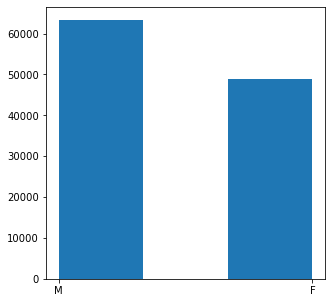

Male Patients: 63340
Female Patients: 48780
There are 1.3 male patients for every female patient.


In [16]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, df.Patient_Gender == "M")))
female_patiens = len(list(filter(None, df.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)
print("There are 1.3 male patients for every female patient.")

## Age distribution

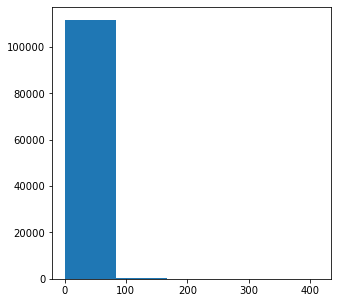

In [17]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Age, bins = 5)
plt.show()

In [18]:
max_age = np.max(df.Patient_Age)
max_age

414

Looks loke the max age is 414, so this ist clearly an error. It also looks like that arround 90 there is a huge dropoff. 

In [19]:
patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
patiens_over_90

51

There are only 51 patients of age 91 or older. Because this is only a small amount we can remove these patients from the dataset. This will result in a dataset with more quality data.

In [20]:
is_not_over_90 =  df.Patient_Age < 91
df = df[is_not_over_90]

patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
patiens_over_90

0

Min Age: 1
Max Age: 90
Mean Age: 46.85832835128358
Median Age: 49.0



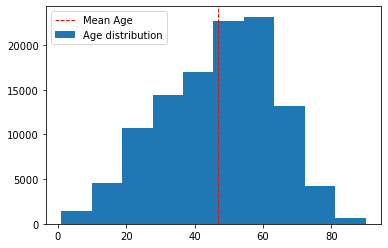

In [21]:
mean_age = np.mean(df.Patient_Age)
median_age = np.median(df.Patient_Age)
min_age = np.min(df.Patient_Age)
max_age = np.max(df.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(df.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

The resulting dataset consists of patients from the age of 1 to 90. The mean age ist 47, the median age is 49.

## View Position: X-ray orientation

In [22]:
print(set(df.View_Position))

{'AP', 'PA'}


The standard chest radiograph is acquired with the patient standing up, and with the X-ray beam passing through the patient from Posterior to Anterior (PA).
Sometimes it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand (AP). The chest X-ray image is still viewed as if looking at the patient face-to-face.

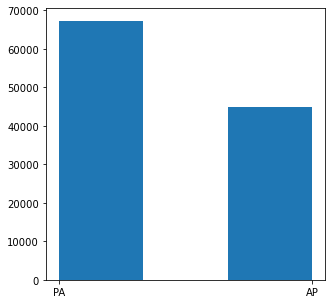

PA: 67277
AP: 44792


In [23]:
plt.figure(figsize=(5,5))
plt.hist(df.View_Position, bins = 3)
plt.show()

PA = len(list(filter(None, df.View_Position == "PA")))
AP = len(list(filter(None, df.View_Position == "AP")))
print("PA:", PA)
print("AP:", AP)

Does the position change with the number of follow ups?

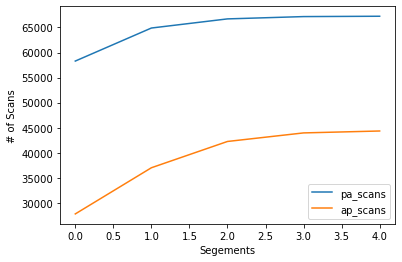

In [24]:
under_10_follow_ups = df["Follow-up_#"] < 11
under_25_follow_ups = df["Follow-up_#"] < 26
under_50_follow_ups = df["Follow-up_#"] < 51
under_80_follow_ups = df["Follow-up_#"] < 81
under_100_follow_ups = df["Follow-up_#"] < 101

pa_scans = []
ap_scans = []

for segment in [under_10_follow_ups, under_25_follow_ups, under_50_follow_ups, under_80_follow_ups, under_100_follow_ups]:
    tmp_df = df[segment]
    PA = len(list(filter(None, tmp_df.View_Position == "PA")))
    AP = len(list(filter(None, tmp_df.View_Position == "AP")))
    pa_scans.append(PA)
    ap_scans.append(AP)

plt.plot(pa_scans, label = "pa_scans")
plt.plot(ap_scans, label = "ap_scans")
plt.xlabel('Segements')
plt.ylabel('# of Scans')
plt.legend()
plt.show()

The number of AP-Scans does increase a little bit more than the number of PA-Scans the more follow ups a patient has. This can mean that sicker patients get more AP-Scans, wich would make sense.

## Case distribution

The number of cases including the number of pneumonia cases and the number of non-pneumonia cases

In [25]:
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

d = df.copy()

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)
d.head(1)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0


In [26]:
d[all_labels].sum()/len(d)

Atelectasis           0.103079
Cardiomegaly          0.024762
Consolidation         0.041635
Edema                 0.020541
Effusion              0.118793
Emphysema             0.022450
Fibrosis              0.015026
Hernia                0.002026
Infiltration          0.177453
Mass                  0.051549
No Finding            0.538347
Nodule                0.056456
Pleural_Thickening    0.030169
Pneumonia             0.012760
Pneumothorax          0.047301
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

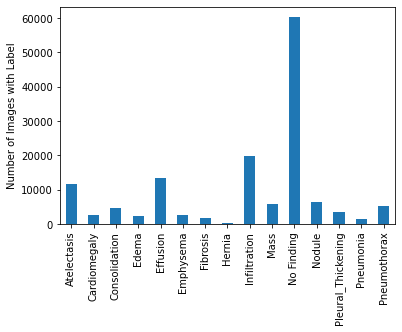

In [27]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The dataset includes 14 pathologies:

* Atelectasis
* Consolidation
* Infiltration
* Pneumothorax
* Edema
* Emphysema
* Fibrosis
* Effusion
* Pneumonia
* Pleural thickening
* Cardiomegaly
* Nodule
* Mass
* Hernia

The most common value though is "No Finding" with 54%. Pneumonia does occur in around 1% of all patients. The second most finding ist "Infiltration" with 18 %.

In [28]:
pneumonia_cases = d[d.Pneumonia==1].shape[0]
print("There are ", pneumonia_cases, " records with Pneumonia listet in the Finding Labes column")

There are  1430  records with Pneumonia listet in the Finding Labes column


Pneumonia is sometimes not the only finding listet in the findings column. Let's look at the 30 most common co-occurrences:

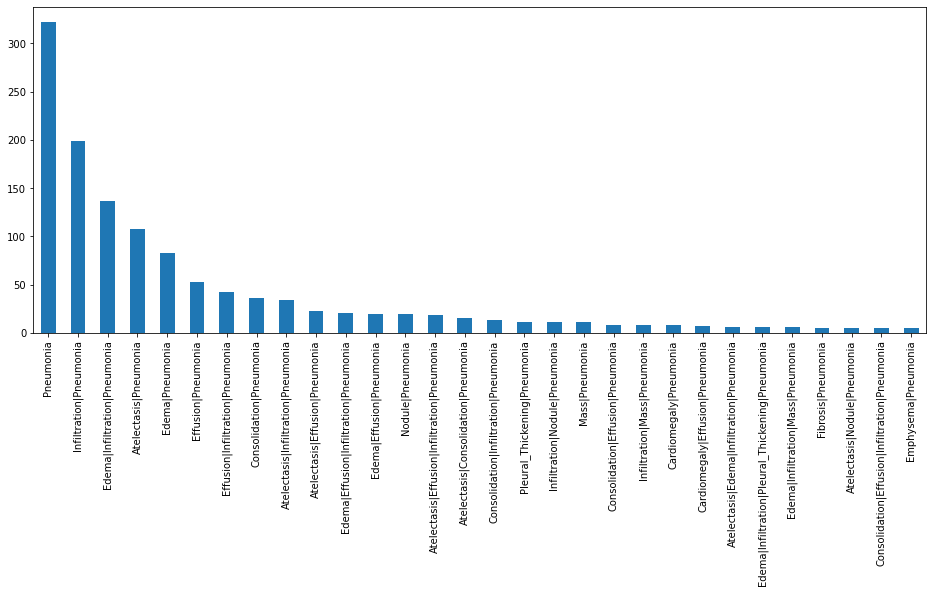

In [29]:
plt.figure(figsize=(16,6))
d[d.Pneumonia==1]['Finding_Labels'].value_counts()[0:30].plot(kind='bar')

It looks like that Pneumonia occurs most often alone. The most often co-occurrence is Infiltration. The third most often case is Pneumonia with Infiltration and Edema. The fourth most common co-occurrence ist with Atelectasis. The fourth most common case is Pneumonia with Edema.

Now let's look with a little bit more detail on the patients who do have Pneumonia

In [30]:
d_pneumonia = d[['Patient_ID', 'Finding_Labels', 'Follow-up_#', 'Patient_ID', 'Patient_Age', 'Patient_Gender', 'Pneumonia']].copy()
has_pneumonia =  d_pneumonia['Pneumonia'] == 1
d_pneumonia = d_pneumonia[has_pneumonia]

d_pneumonia.head()

,Patient_ID,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,Pneumonia
48,13,Effusion|Pneumonia|Pneumothorax,10,13,60,M,1
126,32,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,1
253,56,Nodule|Pneumonia,0,56,76,M,1
276,61,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,1
279,61,Pneumonia,15,61,77,M,1


## Gender distribution of Pneumonia patients

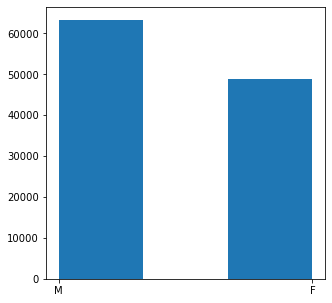

Male Patients: 837
Female Patients: 593
1.41 male to female patients


In [32]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "M")))
female_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)
print(round(male_patiens / female_patiens, 2), "male to female patients")

The gender distribution is almost the same as in the global population (the global population had a 1.3 male to female ratio)

## Age distribution of Pneumonia patients

Min Age: 2
Max Age: 90
Mean Age: 44.67062937062937
Median Age: 46.0



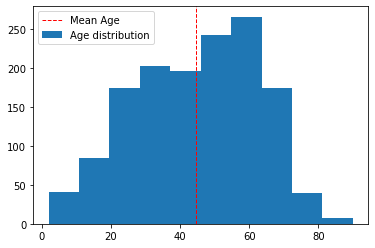

In [33]:
mean_age = np.mean(d_pneumonia.Patient_Age)
median_age = np.median(d_pneumonia.Patient_Age)
min_age = np.min(d_pneumonia.Patient_Age)
max_age = np.max(d_pneumonia.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(d_pneumonia.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

Patients with Pneumonia tend to be 2-3 years younger than the global population. The mean age globally was 46.85, the median was 49. People at arround 55-60 are most likely to have Pneumonia.

## Number of diseases per patient

In [34]:
# Create a new df with all the patients where the Finding_Labels columns does not include "No Finding"
d = df[['Patient_ID', 'Finding_Labels']].copy()
is_sick = d['Finding_Labels'] != "No Finding"
d = d[is_sick]
d["number_of_diseases"] = ""

for index, row in d.iterrows():
    d.at[index,'number_of_diseases'] = len(row['Finding_Labels'].split("|"))

d.head()

,Patient_ID,Finding_Labels,number_of_diseases
0,1,Cardiomegaly,1
1,1,Cardiomegaly|Emphysema,2
2,1,Cardiomegaly|Effusion,2
4,3,Hernia,1
5,3,Hernia,1


In [35]:
print("There are ", d.shape[0], " patients with at least a single finding left.")

There are  51737  patients with at least a single finding left.


In [36]:
# Create a dict to store the dieseases and the number of diseases per patient
# Patients can occur several times in the dataset, so we need to sum the findings per patient
data = {}
unique_patients = []
for index, row in d.iterrows():
    patient_id = row["Patient_ID"]
    unique_patients.append(patient_id)
    if not patient_id in data:   
        data[patient_id] = []
    for e in row['Finding_Labels'].split("|"):
        data[patient_id].append(e)
    data[patient_id] =  data[patient_id]
    
for key, value in data.items():
    data[key] = {
        "diseases": set(value),
        "number_of_diseases": len(set(value))
    }

data[1]

{'diseases': {'Cardiomegaly', 'Effusion', 'Emphysema'},
 'number_of_diseases': 3}

In [37]:
print("There are", len(set(unique_patients)), "unique patients with at least one finding in the dataset")

There are 14394 unique patients with at least one finding in the dataset


In [38]:
# key = number of diseases
# value = number of patients
number_of_diseases = {}
for key, value in data.items():
    if not value["number_of_diseases"] in number_of_diseases:   
        number_of_diseases[value["number_of_diseases"]] = 0
    number_of_diseases[value["number_of_diseases"]] = number_of_diseases[value["number_of_diseases"]] + 1

number_of_diseases 

{3: 1636,
 2: 2906,
 1: 6740,
 10: 84,
 4: 1086,
 8: 204,
 5: 708,
 6: 516,
 7: 336,
 11: 28,
 9: 139,
 12: 7,
 13: 4}

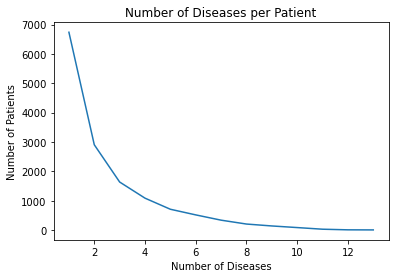

In [39]:
lists = sorted(number_of_diseases.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Number of Diseases per Patient')
plt.show()

Many patients in the dataset have only one illness (6,740). With the number of findings going up, the number of patients does go down. It is interesting to see, that there are seven patiens with 12 findings and 3 patients with 13 findings.

## Image Data assessments

In [42]:
dcm_data = []
for file_path in glob("./" + "test?.dcm"): 
    dcm = dcmread(file_path)
    dcm_data.append(dcm)

len(dcm_data)

6

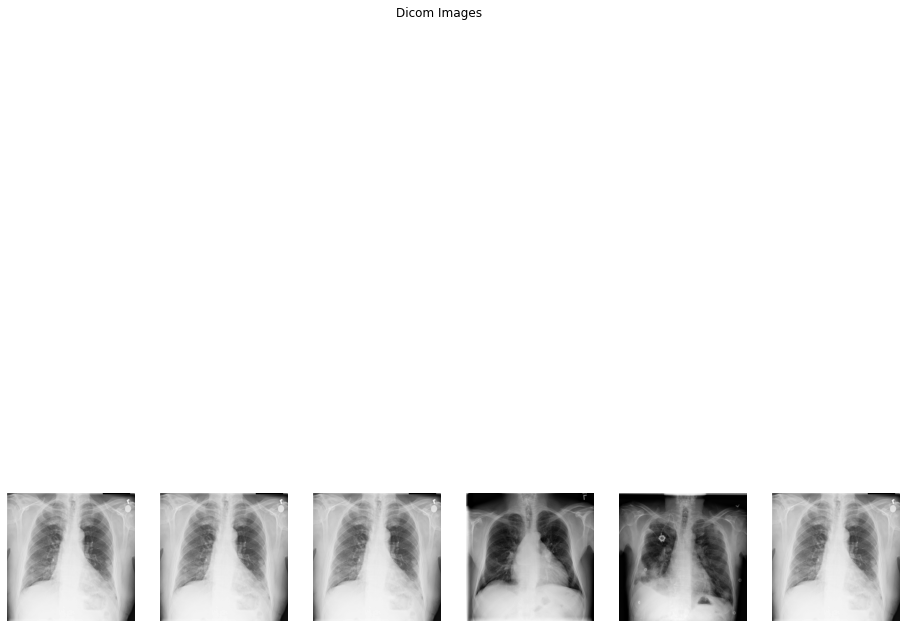

In [52]:
fig, axs = plt.subplots(1, len(dcm_data), figsize = (16, 16))
fig.suptitle('Dicom Images')

for index, dcm in enumerate(dcm_data):
    axs[index].imshow(dcm.pixel_array, cmap='gray')
    axs[index].axis('off')

In [53]:
# data we want to extract from the dcom file
keywords = [
 'PatientID',
 'PatientAge',
 'StudyDescription',
 'PatientPosition',
 'Modality',
 'PatientSex',
]

In [54]:
df_data = []

for index, dcm in enumerate(dcm_data):
    d = []
    for key in keywords:
        d.append(dcm[key].value)
    df_data.append(d)

df_dcom = pd.DataFrame(df_data, columns = keywords) 
df_dcom.head(6)

,PatientID,PatientAge,StudyDescription,PatientPosition,Modality,PatientSex
0,2,81,No Finding,PA,CT,M
1,2,81,No Finding,PA,DX,M
2,2,81,No Finding,XX,DX,M
3,1,58,Cardiomegaly,AP,DX,M
4,61,77,Effusion,AP,DX,M
5,2,81,No Finding,PA,DX,M


In [55]:
## helper function standardize the image
def standardize_image(imageData):
    # Find the mean and std dev intensity values of the image, and standerdize it
    mean_intensity = np.mean(imageData)
    std_intensity = np.std(imageData)
    new_img = imageData.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    return new_img

Are the images of the patient with the id 2 identical?

In [56]:
no_findings =  df_dcom['StudyDescription'] == 'No Finding'
df_dcom_no_findings = df_dcom[no_findings]
df_dcom_no_findings.head()

,PatientID,PatientAge,StudyDescription,PatientPosition,Modality,PatientSex
0,2,81,No Finding,PA,CT,M
1,2,81,No Finding,PA,DX,M
2,2,81,No Finding,XX,DX,M
5,2,81,No Finding,PA,DX,M


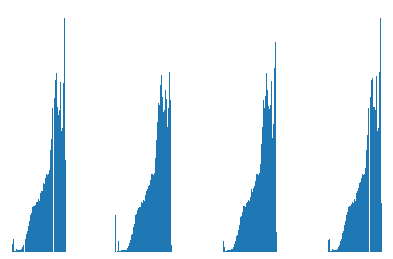

In [61]:
fig, axs = plt.subplots(1, 4)
fig.tight_layout()

c = 0
for index, row in df_dcom_no_findings.iterrows():
    pixel_data = dcm_data[index].pixel_array
    std_image = standardize_image(pixel_data)
    axs[c].hist(std_image.ravel(), bins = 256)
    axs[c].axis('off')
    c = c+1

The desitiy values for patient 2 look very identical on every image

## How do images with findings look like?

In [59]:
findings =  df_dcom['StudyDescription'] != 'No Finding'
df_dcom_findings = df_dcom[findings]
df_dcom_findings.head()

,PatientID,PatientAge,StudyDescription,PatientPosition,Modality,PatientSex
3,1,58,Cardiomegaly,AP,DX,M
4,61,77,Effusion,AP,DX,M


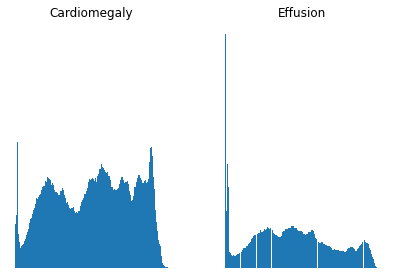

In [62]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout()

c = 0
for index, row in df_dcom_findings.iterrows():
    pixel_data = dcm_data[index].pixel_array
    std_image = standardize_image(pixel_data)
    axs[c].hist(std_image.ravel(), bins = 256)
    axs[c].set_title(row["StudyDescription"])
    axs[c].axis('off')
    c = c+1

The images with a finding (Effusion or Cardiomegaly), both look very different than the images with no findings.

## Summary
In the dataset there are 112,120 chest x-rays with disease labels acquired from 30,000 patients. These x-rays originate from 63,340 male and 48,780 female patients. The ages ranges from 1 to 90, the mean age is 47, the median age is 49.

Many patients in the dataset have only one illness (6,740). With the number of findings going up, the number of patients does go down. 

The most common finding in the dataset is "No Finding" with 54%. The second most finding ist "Infiltration" with 18 %. Pneumonia does occur in around 1% of all patients. Furthermore, Pneumonia occurs most often alone. The most often co-occurrence with Pneumonia is Infiltration. The third most often case is Pneumonia with Infiltration and Edema. The fourth most common co-occurrence ist Pneumonia with Atelectasis. The fourth most common case is Pneumonia with Edema.
The patients with Pneumonia are not that different to the global population, the gender and age distribution are almost identical.

As already stated in the README.md, the diagnosis of pneumonia from chest X-rays is difficult for several reasons: 
1. The appearance of pneumonia in a chest X-ray can be very vague depending on the stage of the infection
2. Pneumonia often overlaps with other diagnoses
3. Pneumonia can mimic benign abnormalities

For these reasons, it is important to build a classifier which will take the demographic data of the patient and even older x-rays into account. Also it will be important that the classifier can detect Pneumonia together with other diseases, because Pneumonia does often occur together with other illnesses. 